In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from scipy.integrate import ode, odeint, solve_ivp
from scipy.optimize import minimize
from scipy.stats import dirichlet

# import DOE library
from doepy import build
from scipy.stats.qmc import Sobol
import itertools

params = {'legend.fontsize': 18,
          'figure.figsize': (7, 5),
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'axes.linewidth':3,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
plt.style.use('default')
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(1248790523) 

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def generate_params(n_r, n_s, d_r=2, d_s=2):
    
    # init consumer matrix
    C = np.ones([n_r, n_s])
    
    # assume half of resources can't be produced
    # makes system more sensitive to initial resource condition
    row = 0
    col = 0
    
    while row < n_r:
        # random depth (number of resources to depend on species)
        r_depth = np.random.randint(1, d_r+1)
        s_depth = np.random.randint(1, d_s+1)
        
        # delete elements of C matrix
        if col+s_depth < n_s-2:
            C[row+r_depth:, :col+s_depth] = 0.
            row += r_depth
            col += s_depth
        else:
            C[row+r_depth:, :-2] = 0.
            break
        
    # populate producer matrix
    P = 1. + C - 2.*C
      
    # poke holes in C and P matrices (so that not all species consume/produce)
    C *= np.random.randint(0, 2, [n_r, n_s])
    P *= np.random.randint(0, 2, [n_r, n_s])
     
    # assign coefficients (sum over rows of C should be all be similar)
    species_consumption = 1. + 0.1*np.random.randn(n_s)
    C = (species_consumption / np.sum(C, 0)) * C
    
    n = np.sum(P, 1)
    resource_production = 1. + 0.1*np.random.randn(sum(n>0))
    n[n>0] = resource_production/n[n>0]
    P = (n*P.T).T
        
    return C, P

In [3]:
# number of species 
n_s = 5
# having fewer resources causes resources (and species?) to deplete faster
n_r = 5
# number of species that produce target 
n_s2t = 2

# define time steps to sample data
t_batch  = 160 # hr
t_samples =  8 # how many times to collect data
t_delta = t_batch // t_samples 
t_eval  = np.arange(0, t_batch+t_delta, t_delta)

# number of low fidelity samples (number of plates)
NS_LF = 64

# percent noise to add to data 
noise = .001

# efficiency of consumers
eps = .75

# generate consumer and producer matrices 
C, P = generate_params(n_r, n_s, 2, 2)

# death rate of consumers 
d_s = 1/100 # np.mean(C, 0)/10 * np.random.randn(n_s)

# degradation rate of resources
d_r = 1/100

# sum of species abundance
s_total = .1 * n_s
s_vals  = lambda s: .1*s #s / np.sum(s) * s_total

# sum of resource concentration
r_total = 1. * n_r
r_vals  = lambda r: r / np.sum(r) * r_total

# full factorial of species abundances 
s_0s = np.array([np.array(i) for i in itertools.product([0, 1], repeat = n_s)])[1:] 
# remove mono culture
mono_inds = np.sum(s_0s, 1)==1
s_0s = s_0s[~mono_inds]

# + Sobol sequencing 
sampler = Sobol(d=n_s)
X = sampler.random(NS_LF)
s_0s = np.concatenate((s_0s, X))

# consider full set of resources
r_0 = np.ones(n_r)

In [4]:
# target production depends on a subset of species in last layer
Yps = np.zeros(n_s)
# randomly assign m \in {1, ..., n_s} of the vector to have non-zero values
inds = np.arange(len(Yps))
np.random.shuffle(inds)
Yps[inds[:n_s2t]] = np.abs(np.random.randn(n_s2t)) 
Yps

# toxicity of target on species 
Ysp = np.zeros(n_s)
# randomly assign m \in {1, ..., n_s} of the vector to have non-zero values
inds = np.arange(len(Yps))
np.random.shuffle(inds)
Ysp[inds[:n_s2t]] = np.abs(np.random.randn(n_s2t))/10.
Ysp = np.abs(np.random.randn(n_s)/300.)
Ysp

array([0.00122143, 0.00665306, 0.00548764, 0.01017995, 0.00620996])

In [5]:
# define system of equations
def reactor(t, y):
    
    # y should never be negative
    y = np.clip(y, 0, np.inf)
    
    # species 
    s = y[:n_s]
    
    # resources
    r = y[n_s:-1]
    
    # product
    p = y[-1]
    
    # rate of change of species 
    dsdt = s*(eps*C.T@(r/(r+n_r)) - d_s)

    # rate of change of resources (only positive elements of consumer matrix)
    drdt = -r*((C*np.array(C>0, int))@s + d_r) + P@s
    
    # rate of change of product
    dpdt = np.dot(Yps, s) 

    return np.append(np.append(dsdt, drdt), dpdt)
    # return np.append(dsdt, drdt)

[0.06731472 0.0657288  0.03102968 0.05708814 0.05472396]


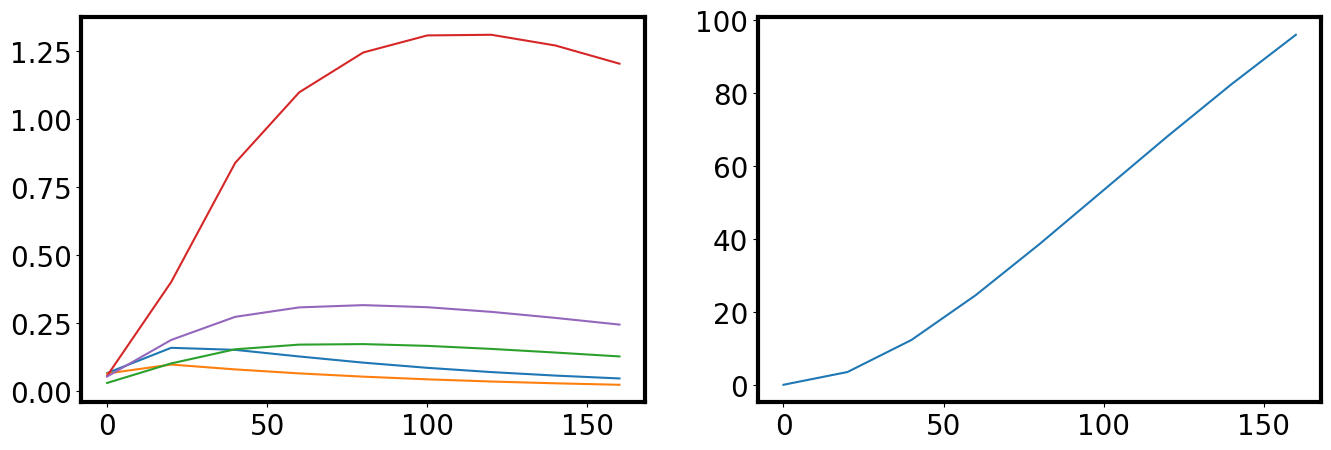

[0.09791707 0.0143711  0.08424955 0.07197713 0.02521105]


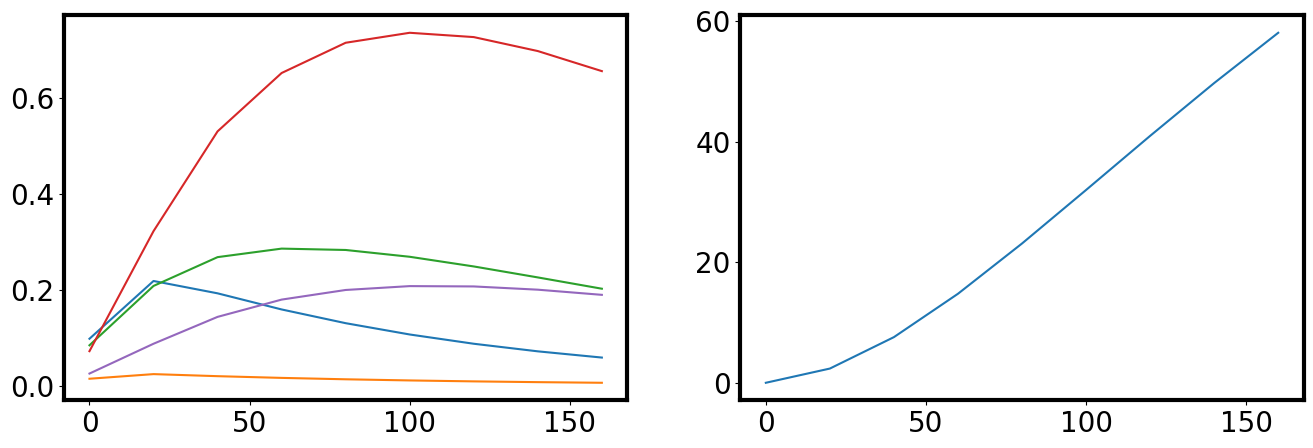

[0.1 0.1 0.1 0.1 0.1]


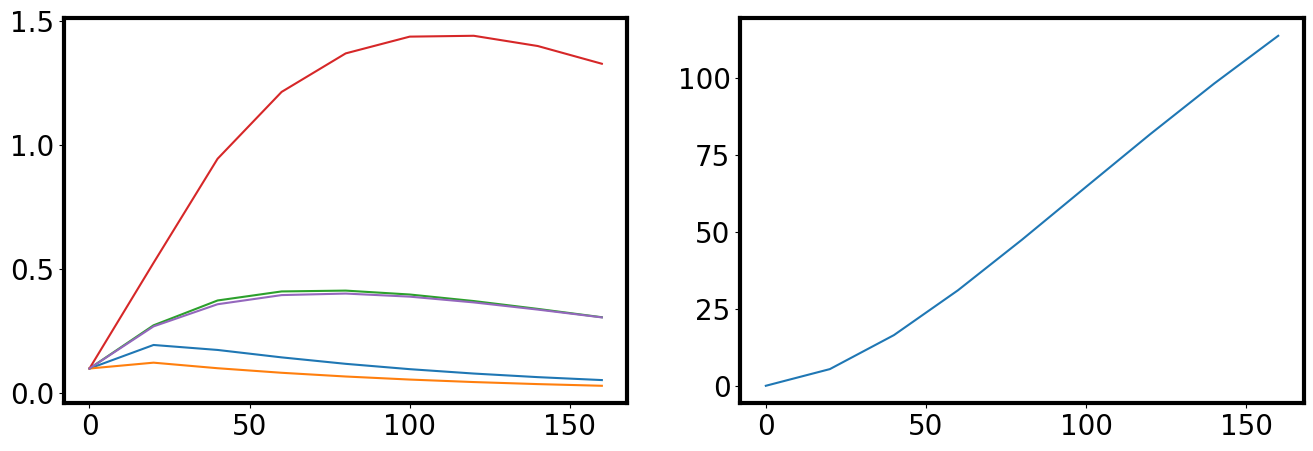

[0.00433723 0.06840052 0.06534499 0.02483992 0.03487336]


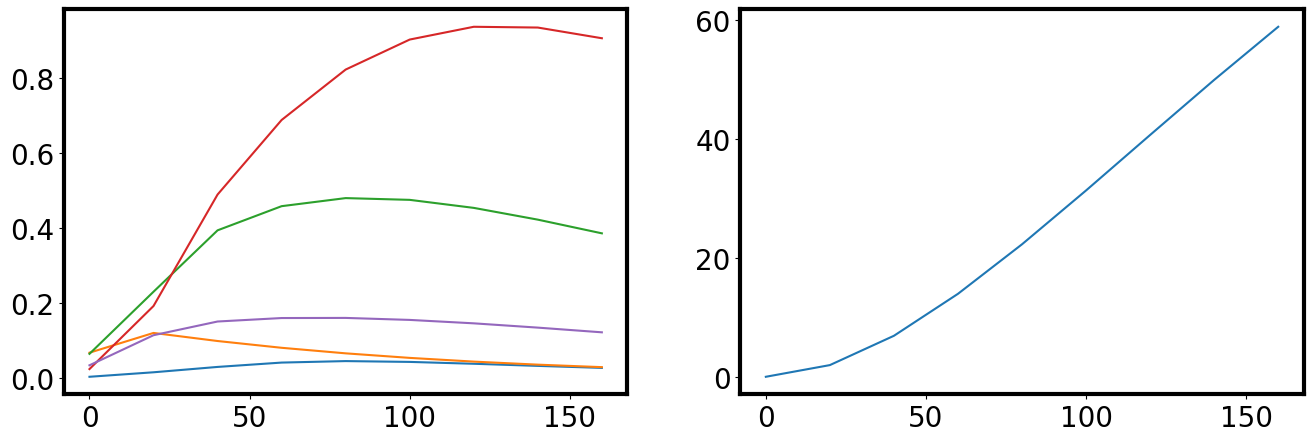

[0.04317869 0.07573527 0.05190768 0.00684565 0.0887058 ]


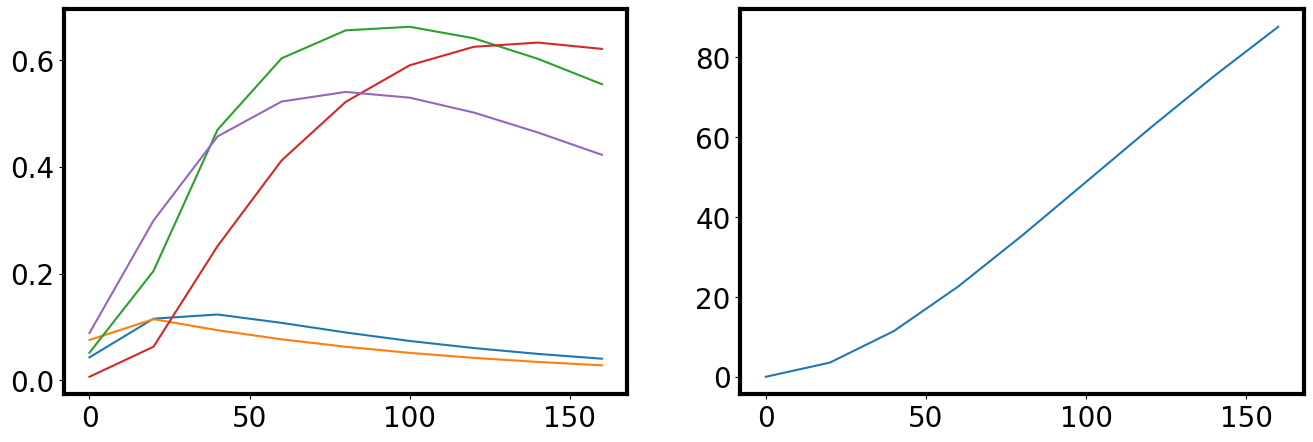

[0.09406725 0.0828916  0.01567456 0.01946659 0.0500194 ]


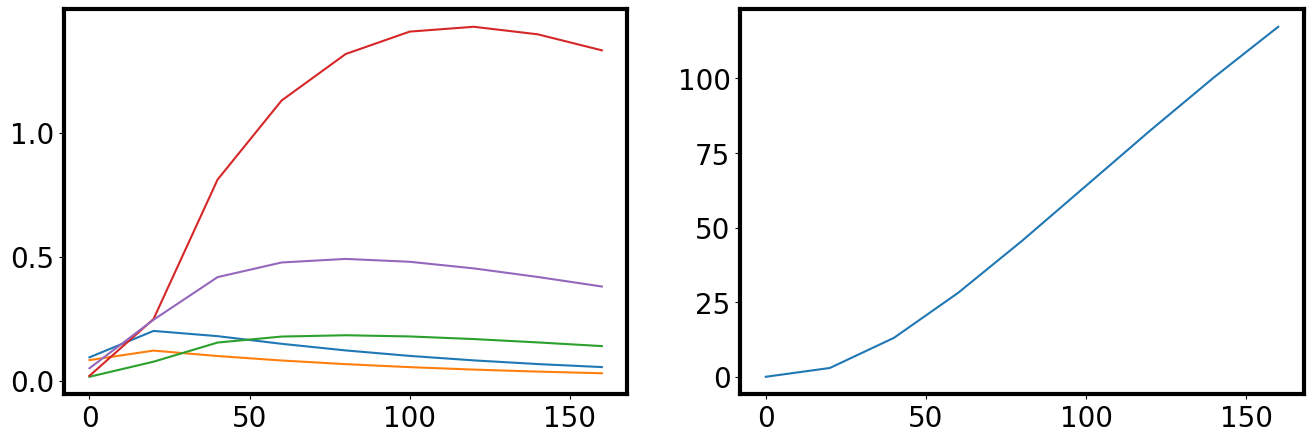

[0.08338447 0.06110289 0.00722295 0.03111458 0.02768257]


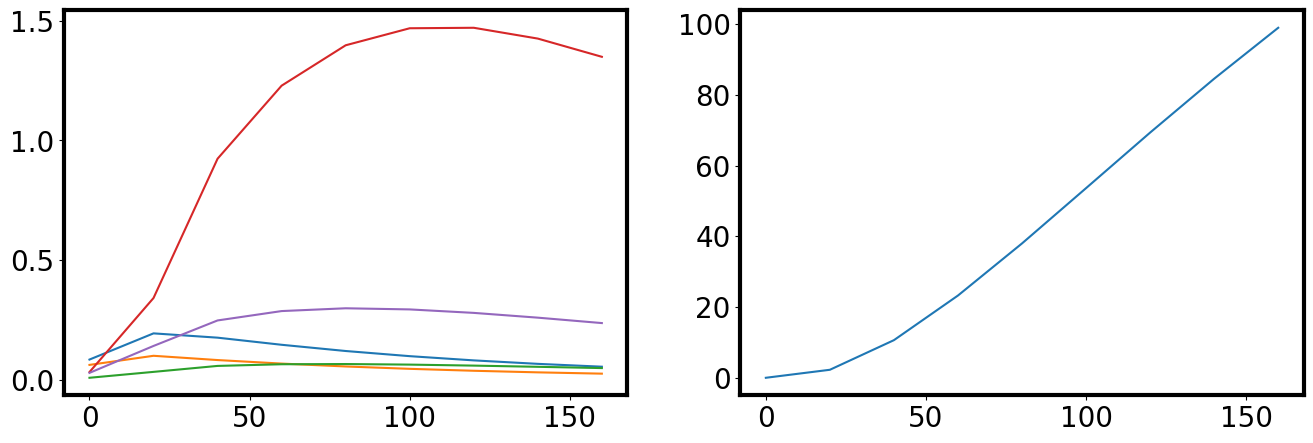

[0.1 0.1 0.  0.  0.1]


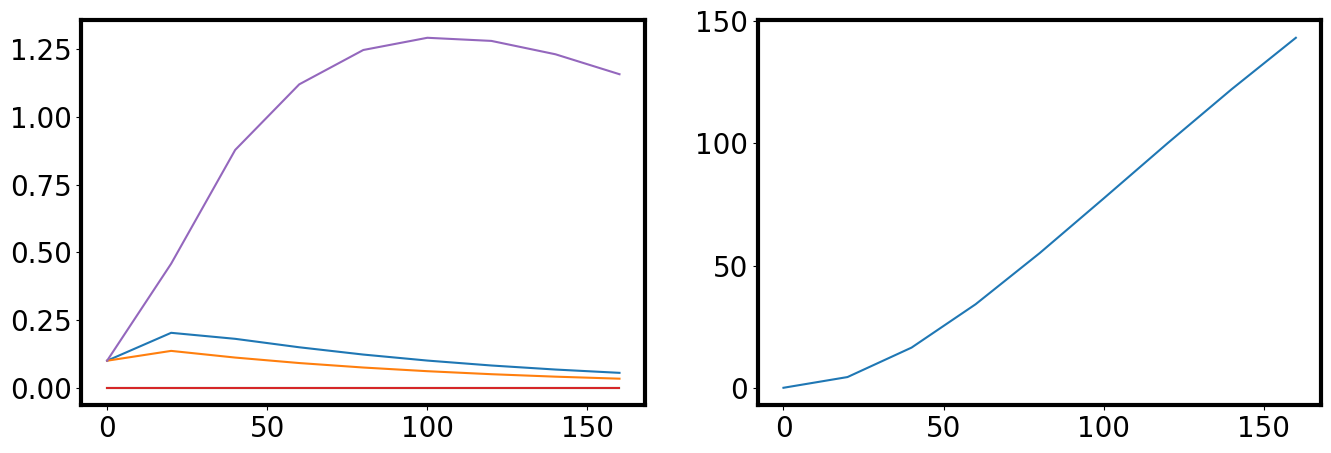

[0.04552859 0.00607747 0.06803096 0.06750458 0.03782394]


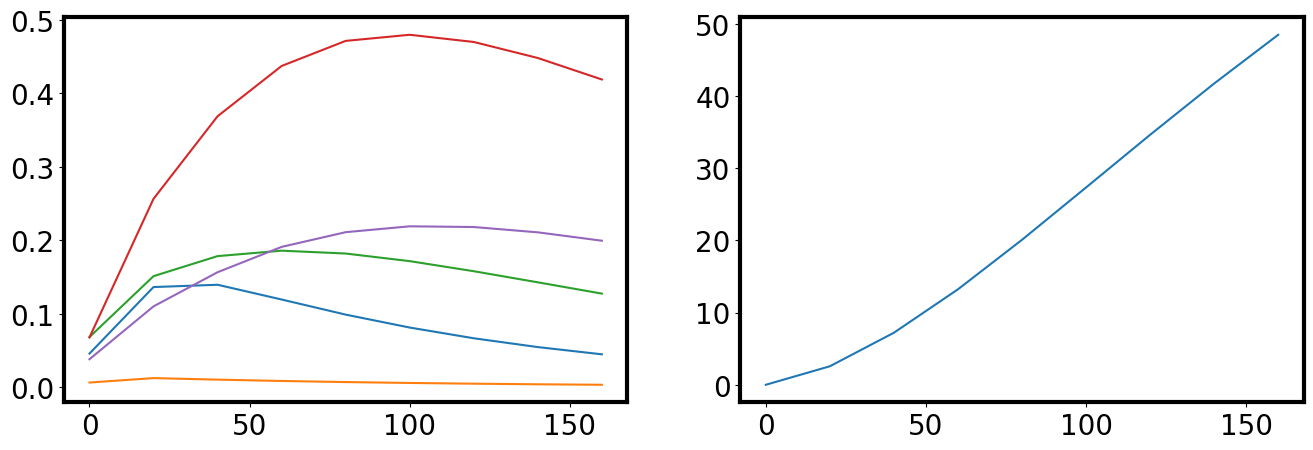

[0.01345835 0.05117315 0.02145171 0.05260073 0.06730037]


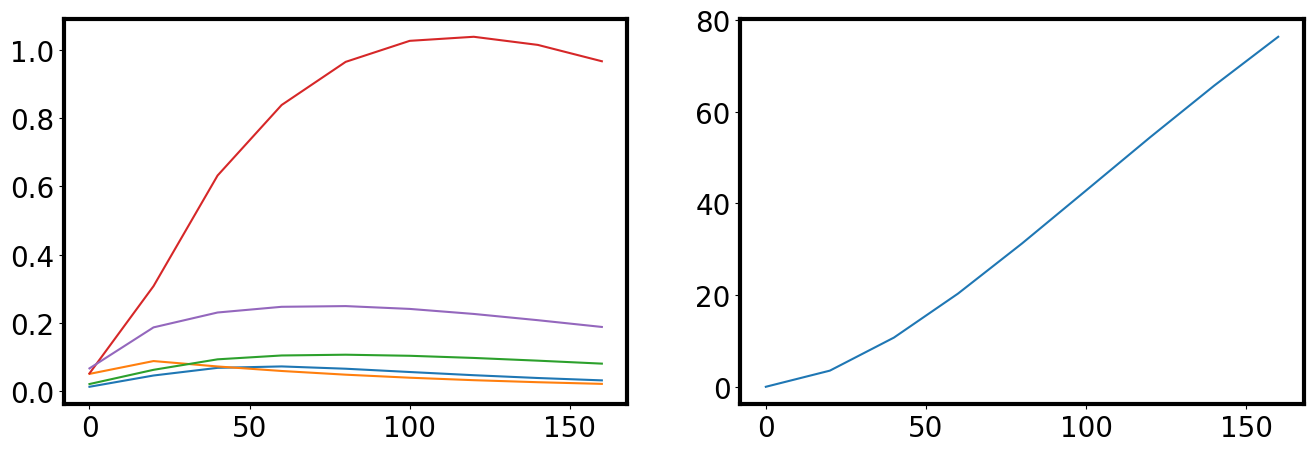

[0.05204621 0.05170616 0.08703224 0.01683686 0.04730305]


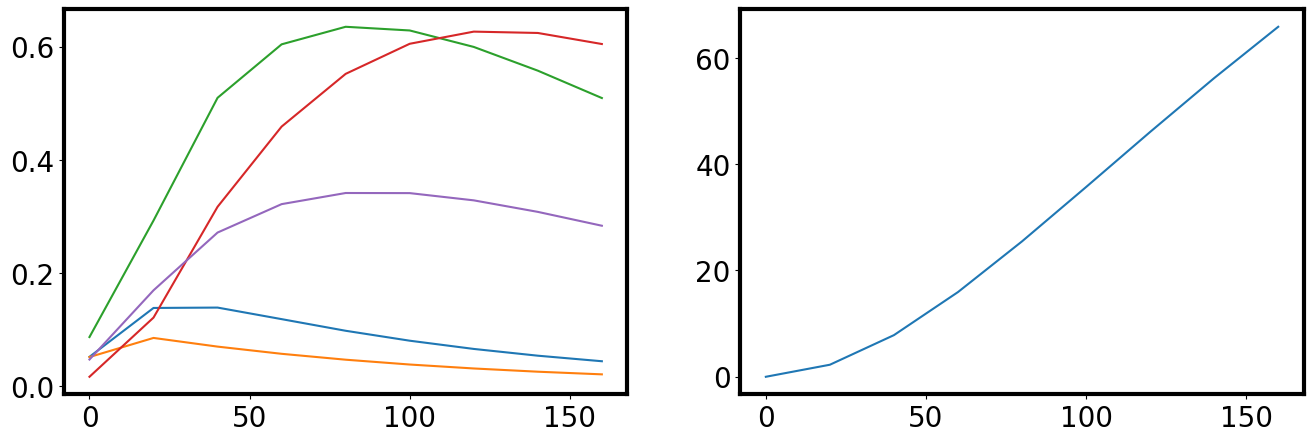

[0.02451524 0.08508851 0.02825148 0.04579368 0.08625594]


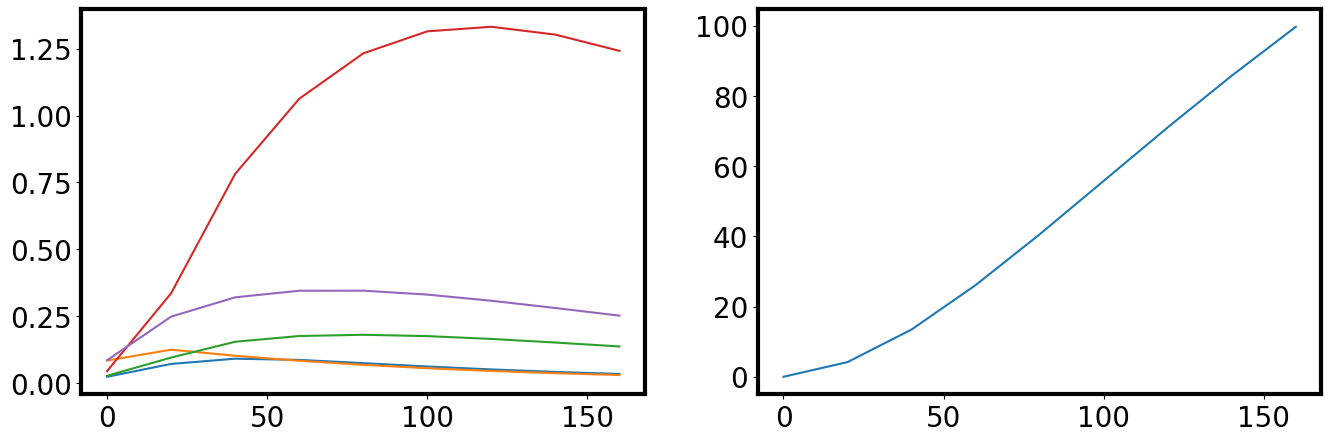

[0.1 0.  0.  0.1 0.1]


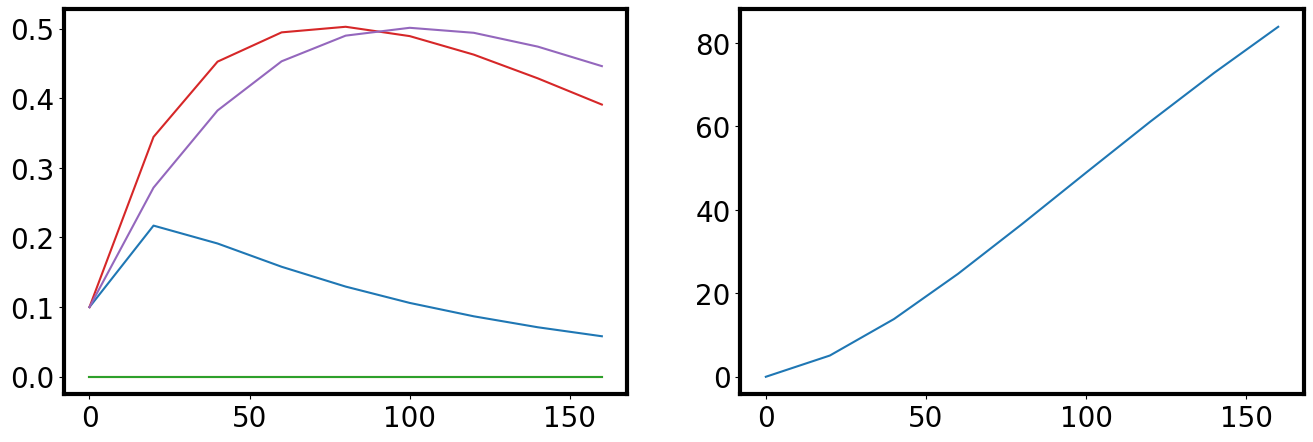

[0.02056776 0.01608039 0.07182516 0.09870018 0.01106925]


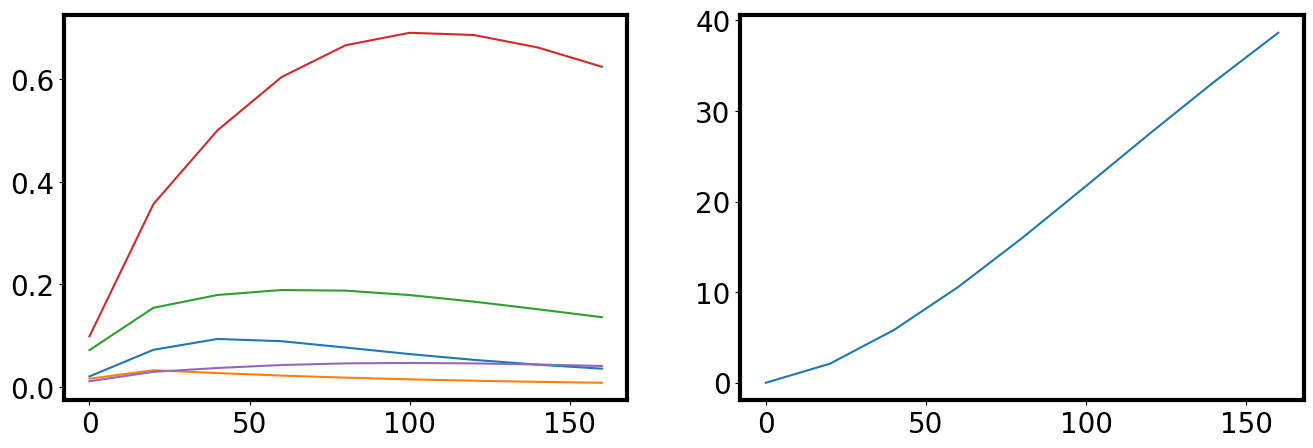

[0.1 0.1 0.  0.1 0.1]


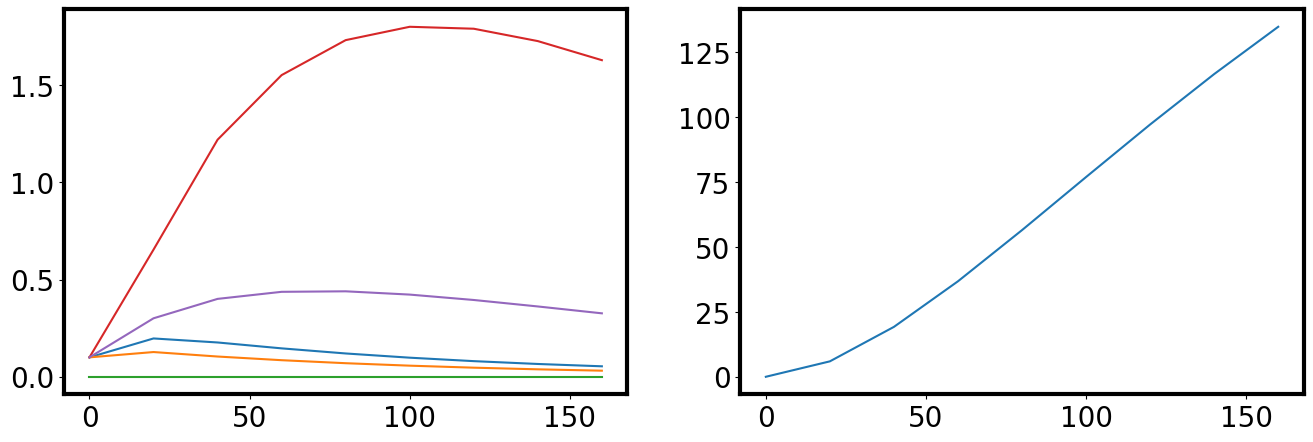

In [6]:
for i in np.random.choice(np.arange(s_0s.shape[0]), 15, replace=False):
    # initial set of species and resources and product
    y_0 = np.append(np.append(s_vals(s_0s[i]), r_vals(r_0)), 0.)
    print(y_0[:n_s])

    # define more time steps to sample data
    # t_delta = t_batch // 50
    soln = solve_ivp(reactor, (0, t_batch), y_0, 
                     t_eval=np.arange(0, t_batch+t_delta, t_delta), method='LSODA')

    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, t_batch+t_delta, t_delta), soln.y[:n_s].T)

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, t_batch+t_delta, t_delta), soln.y[-1].T)
    plt.show()

# Save to dataframe

In [7]:
# Data matrix with columns [Time, s1, ..., sn, r1, ..., rm, product]
D = np.zeros([len(t_eval)*s_0s.shape[0], 2+n_s])

# save exp names for feed condition 
exp_names = []

k = 0
for s_0 in s_0s:
    # set initial conditions
    IC = s_vals(s_0)
    y_0 = np.append(np.append(IC, r_vals(r_0)), 0.)
    
    # solve ode
    soln = solve_ivp(reactor, (0, t_batch), y_0, t_eval=t_eval, method='LSODA')
    
    # save species abundance and add noise
    y = soln.y.T[:, :n_s]
    y[1:] = y[1:] + noise*np.random.randn(y.shape[0]-1, y.shape[1])
    
    # make sure initially zero species stay zero regardless of noise
    y = np.einsum("j,ij-> ij", np.array(IC > 0, float), y)
    y = np.clip(y, 0, np.inf)

    # store data
    exp_names+= [f"Exp_{k}"]*len(t_eval)

    # store measurement times
    D[k*len(t_eval):(k+1)*len(t_eval), 0] = t_eval
    
    # store sum of OD
    D[k*len(t_eval):(k+1)*len(t_eval), 1] = np.sum(y, 1)
    
    # store species abundance, resource concentration, product concentration 
    D[k*len(t_eval):(k+1)*len(t_eval), 2:] = y

    # counter
    k+=1

# save dataframe
df = pd.DataFrame()
df['Experiments'] = exp_names
columns = ['Time'] + ["OD"] + ['s'+str(i+1) for i in range(n_s)]
for j,col in enumerate(columns):
    df[col] = D[:, j]

df.to_csv("CR_data_sum.csv", index=False)
df

,Experiments,Time,OD,s1,s2,s3,s4,s5
0,Exp_0,0.0,0.200000,0.000000,0.000000,0.000000,0.100000,0.100000
1,Exp_0,20.0,0.463590,0.000000,0.000000,0.000000,0.268503,0.195087
2,Exp_0,40.0,0.406714,0.000000,0.000000,0.000000,0.243607,0.163107
3,Exp_0,60.0,0.333278,0.000000,0.000000,0.000000,0.199142,0.134135
4,Exp_0,80.0,0.275383,0.000000,0.000000,0.000000,0.164233,0.111150
...,...,...,...,...,...,...,...,...
805,Exp_89,80.0,1.571290,0.098141,0.045170,0.016721,1.162930,0.248328
806,Exp_89,100.0,1.588626,0.080053,0.034787,0.014483,1.216704,0.242599
807,Exp_89,120.0,1.554661,0.067091,0.029417,0.013488,1.215250,0.229416
808,Exp_89,140.0,1.481062,0.053449,0.024978,0.013340,1.174889,0.214407


In [8]:
# full factorial of species abundances 
s_0s = np.array([np.array(i) for i in itertools.product([0, 1], repeat = n_s)])[1:] 
# remove mono culture
mono_inds = np.sum(s_0s, 1)==1
s_0s = s_0s[~mono_inds]

# define time steps to sample data
t_samples =  2 # how many times to collect data
t_delta = t_batch // t_samples 
t_eval  = np.arange(0, t_batch+t_delta, t_delta)

# Data matrix with columns [Time, s1, ..., sn, r1, ..., rm, product]
D = np.zeros([len(t_eval)*s_0s.shape[0], 2+n_s])

# save exp names for feed condition 
exp_names = []

k = 0
for s_0 in s_0s:
    # set initial conditions
    IC = s_vals(s_0)
    y_0 = np.append(np.append(IC, r_vals(r_0)), 0.)
    
    # solve ode
    soln = solve_ivp(reactor, (0, t_batch), y_0, t_eval=t_eval, method='LSODA')
    
    # save species abundance and add noise
    y = soln.y.T[:, :n_s]
    y[1:] = y[1:] + noise*np.random.randn(y.shape[0]-1, y.shape[1])
    
    # make sure initially zero species stay zero regardless of noise
    y = np.einsum("j,ij-> ij", np.array(IC > 0, float), y)
    y = np.clip(y, 0, np.inf)

    # store data
    exp_names+= [f"Exp_{k}"]*len(t_eval)

    # store measurement times
    D[k*len(t_eval):(k+1)*len(t_eval), 0] = t_eval
    
    # store sum of OD
    D[k*len(t_eval):(k+1)*len(t_eval), 1] = np.sum(y, 1)
    
    # store species abundance, resource concentration, product concentration 
    D[k*len(t_eval):(k+1)*len(t_eval), 2:] = y

    # counter
    k+=1

# save dataframe
df = pd.DataFrame()
df['Experiments'] = exp_names
columns = ['Time'] + ["OD"] + ['s'+str(i+1) for i in range(n_s)]
for j,col in enumerate(columns):
    df[col] = D[:, j]

df.to_csv("CR_data_full.csv", index=False)
df

,Experiments,Time,OD,s1,s2,s3,s4,s5
0,Exp_0,0.0,0.200000,0.000000,0.000000,0.000000,0.100000,0.100000
1,Exp_0,80.0,0.274075,0.000000,0.000000,0.000000,0.164661,0.109414
2,Exp_0,160.0,0.123331,0.000000,0.000000,0.000000,0.074001,0.049330
3,Exp_1,0.0,0.200000,0.000000,0.000000,0.100000,0.000000,0.100000
4,Exp_1,80.0,0.272901,0.000000,0.000000,0.143900,0.000000,0.129001
...,...,...,...,...,...,...,...,...
73,Exp_24,80.0,2.418504,0.120600,0.072744,0.485401,1.739759,0.000000
74,Exp_24,160.0,2.094035,0.054466,0.032424,0.354062,1.653083,0.000000
75,Exp_25,0.0,0.500000,0.100000,0.100000,0.100000,0.100000,0.100000
76,Exp_25,80.0,2.374545,0.118330,0.068581,0.414112,1.371025,0.402498
